# 模块导入

In [2]:
import torch
import numpy as np

# Variable

我们导入Variable类。将tensor封装成了这种形式，然后就可以使用Variable的自动求导和反向传播功能了。普通的tensor是没有自动求导的

variable和tensor几乎有一样的接口。方法都通用的

In [4]:
from torch.autograd import Variable

In [4]:
x = Variable(torch.ones(2,3))
x

tensor([[1., 1., 1.],
        [1., 1., 1.]])

In [5]:
x.requires_grad_()

tensor([[1., 1., 1.],
        [1., 1., 1.]], requires_grad=True)

In [7]:
y = x ** 2

In [8]:
y.backward()

RuntimeError: grad can be implicitly created only for scalar outputs

In [9]:
# 上面报错了，使用下面解决。但是为什么呢？
y.backward(torch.ones_like(x))

In [12]:
x.grad

tensor([[2., 2., 2.],
        [2., 2., 2.]])

# torch.nn

如果直接使用Variable来写神经网络，还是会有些吃力的。所以pytorch已经帮我们集成好了模块

torch.nn 就是专门构建神经网络的模块，nn模块是基于自动求导之上的

In [19]:
a = torch.randn(2,3,3)

In [20]:
a

tensor([[[-0.0777,  0.6543,  1.1552],
         [-1.6895,  1.5919, -0.4372],
         [ 0.5987,  0.5051, -1.8900]],

        [[-0.8786,  0.0778, -1.1554],
         [-0.8521,  1.3059, -0.7968],
         [ 0.4149, -1.4787, -0.7642]]])

In [24]:
a[0,...]

tensor([[-0.0777,  0.6543,  1.1552],
        [-1.6895,  1.5919, -0.4372],
        [ 0.5987,  0.5051, -1.8900]])

In [25]:
a[0,:,:]

tensor([[-0.0777,  0.6543,  1.1552],
        [-1.6895,  1.5919, -0.4372],
        [ 0.5987,  0.5051, -1.8900]])

In [26]:
a > 0

tensor([[[False,  True,  True],
         [False,  True, False],
         [ True,  True, False]],

        [[False,  True, False],
         [False,  True, False],
         [ True, False, False]]])

In [27]:
a[a>0]

tensor([0.6543, 1.1552, 1.5919, 0.5987, 0.5051, 0.0778, 1.3059, 0.4149])

# autograd

我们来看一个函数

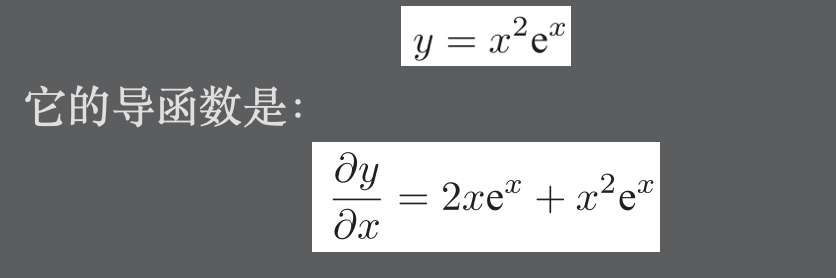

In [29]:
def func(x):
    return x**2 * torch.exp(x)

def pfunc(x):
    return 2*x*torch.exp(x) + x**2 * torch.exp(x)

In [31]:
from torch.autograd import Variable

In [39]:
x = Variable(torch.rand(3,4), requires_grad=True)
# x.requires_grad_()
x

tensor([[0.0187, 0.4892, 0.8931, 0.5635],
        [0.9389, 0.8019, 0.2144, 0.6179],
        [0.6671, 0.7510, 0.1432, 0.4122]], requires_grad=True)

In [40]:
y = func(x)

In [41]:
y.backward(torch.ones_like(x)) # 这里一定要设置形式像要求导的x一样

In [43]:
x.grad

tensor([[0.0385, 1.9859, 6.3121, 2.5381],
        [7.0553, 5.0098, 0.5882, 3.0007],
        [3.4665, 4.3786, 0.3542, 1.5015]])

In [45]:
pfunc(x)

tensor([[0.0385, 1.9859, 6.3121, 2.5381],
        [7.0553, 5.0098, 0.5882, 3.0007],
        [3.4665, 4.3786, 0.3542, 1.5015]], grad_fn=<AddBackward0>)

**我们可以看到这两个反向求导和手动求导的结果差不多**

# 问题说明

## 内存共享

tensor的存储形式，分为信息区和数据区。信息区是存放数据的一些特点，比如shape这些

有些操作会让内存空间共享

在pytorch和numpy中，两个内存是共享的。所以可以相互转换。而且两者转换的开销非常小

In [28]:
a = torch.rand(2,2)

In [29]:
a

tensor([[0.6505, 0.6190],
        [0.8282, 0.8781]])

In [30]:
b = a.view(-1)

In [31]:
b

tensor([0.6505, 0.6190, 0.8282, 0.8781])

In [34]:
b[1] = 0

In [35]:
b

tensor([0.6505, 0.0000, 0.8282, 0.8781])

In [36]:
# 可以发现a，b的存储信息区不是共享的，但是数据是共享的
a

tensor([[0.6505, 0.0000],
        [0.8282, 0.8781]])

In [64]:
b = a.numpy()
# 下面两种方式转换成tensor

In [65]:
a = torch.from_numpy(b)

In [66]:
c = torch.Tensor(b)

有些操作会使得数据不共享

## 数据连续性问题

转置操作会使得数据变得不连续，无法进行view等操作

所以使用下面方式

In [47]:
a = torch.rand(2,3)
a

tensor([[0.4807, 0.0078, 0.4733],
        [0.7317, 0.4364, 0.9317]])

In [48]:
b = a.t()

In [49]:
b

tensor([[0.4807, 0.7317],
        [0.0078, 0.4364],
        [0.4733, 0.9317]])

In [50]:
a[0,0] = 1

In [51]:
a

tensor([[1.0000, 0.0078, 0.4733],
        [0.7317, 0.4364, 0.9317]])

In [53]:
b.is_contiguous()

False

In [54]:
b.view(-1)

RuntimeError: view size is not compatible with input tensor's size and stride (at least one dimension spans across two contiguous subspaces). Use .reshape(...) instead.

In [58]:
# 因为b的数据是不连续的，所以不能使用view操作
b.contiguous()

tensor([[1.0000, 0.7317],
        [0.0078, 0.4364],
        [0.4733, 0.9317]])

In [59]:
b.is_contiguous()

False

In [60]:
b = b.contiguous()

In [62]:
b.is_contiguous()

True

In [63]:
b.view(-1)

tensor([1.0000, 0.7317, 0.0078, 0.4364, 0.4733, 0.9317])

## 广播法则

In [85]:
a = torch.ones(2,1)
a

tensor([[1.],
        [1.]])

In [86]:
b = torch.zeros(2,2,2)
b

tensor([[[0., 0.],
         [0., 0.]],

        [[0., 0.],
         [0., 0.]]])

In [87]:
res = a + b
res.shape

torch.Size([2, 2, 2])

In [92]:
res

tensor([[[1., 1.],
         [1., 1.]],

        [[1., 1.],
         [1., 1.]]])

In [88]:
# 可以发现本来a和b的维度是不一样的，但是两者还是可以相加的
# a是2维，b是3维
# 拓展的规则是这样的：首先找到维度比较低的维度。将维度低的tensor拓展到维度比较高的
a.unsqueeze(0).shape

torch.Size([1, 2, 1])

In [94]:
# 虽然拓展了，但是两个维度的量还是不一样，另外两个都是2.而本来的是1
# 然后通过expand手动拓展到相同。
# 广播机制就像下面的操作一样

a.unsqueeze(0).expand(2,2,2)

tensor([[[1., 1.],
         [1., 1.]],

        [[1., 1.],
         [1., 1.]]])